<a href="https://colab.research.google.com/github/Akshaay1/Financial-Time-Series-Analysis-using-Wavelets/blob/main/Financial_Time_Series_Analysis_using_Wavelets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%matplotlib inline
import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
#pip install piwavelet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install pycwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 758 kB 24.5 MB/s 
  Created wheel for pycwt: filename=pycwt-0.3.0a22-py3-none-any.whl size=17825 sha256=7a6a1eecddd0ae3b2c02d24ab112b1d60a971c64a484d90e92935f3183d0255f
  Stored in directory: /root/.cache/pip/wheels/53/99/6b/a43c99414482c20862ca8917862237de8bd27ee795a55faa6c
Successfully built pycwt


In [3]:
from __future__ import division
import numpy
from matplotlib import pyplot

import pycwt as wavelet
from pycwt.helpers import find

# BITCOIN CWT

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


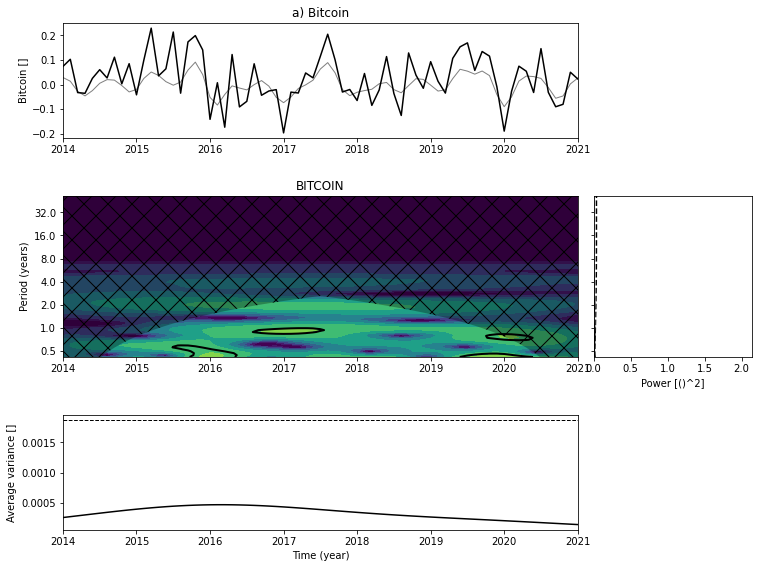

In [6]:
url = '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/bitcoin.txt'
dat = np.genfromtxt(url, skip_header=19)
title = 'Bitcoin'
label = 'Bitcoin'
units = ''
t0 = 2014.0
dt = 0.10  # In years
N = dat.size
t = numpy.arange(0, N) * dt + t0
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
mother = wavelet.Morlet(6)
s0 = 4* dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('BITCOIN')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
#dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

# CONSUMER PRICE INDEX CWT

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


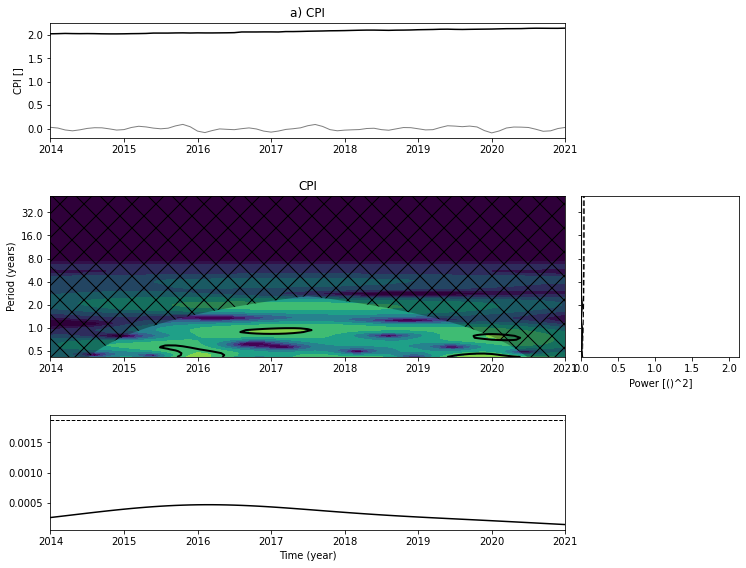

In [7]:
cpi = '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/cpi (1).txt'
dat = numpy.genfromtxt(cpi, skip_header=19)
title = 'CPI'
label = 'CPI'
units = ''
t0 = 2014.0
dt = 0.11  # In years
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('CPI')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
#dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
#dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

# MONEY SUPPLY CWT

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


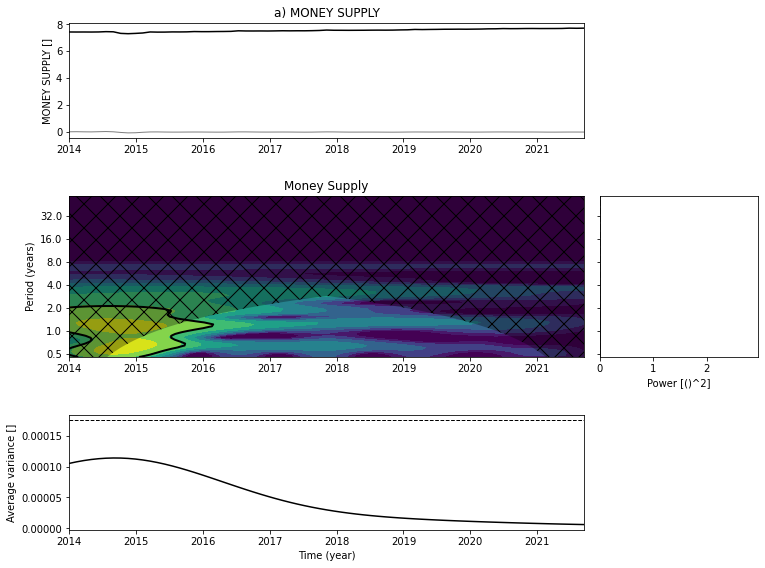

In [8]:
money_supply = '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/Money_supply.txt'
dat = numpy.genfromtxt(money_supply , skip_header=19)
title = 'MONEY SUPPLY'
label = 'MONEY SUPPLY'
units = ''
t0 = 2014.0
dt = 0.11  # In years
N = dat.size
t = numpy.arange(0, N) * dt + t0
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
mother = wavelet.Morlet(6)
s0 = 4* dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
#alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('Money Supply')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
#dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

# GDP CWT

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


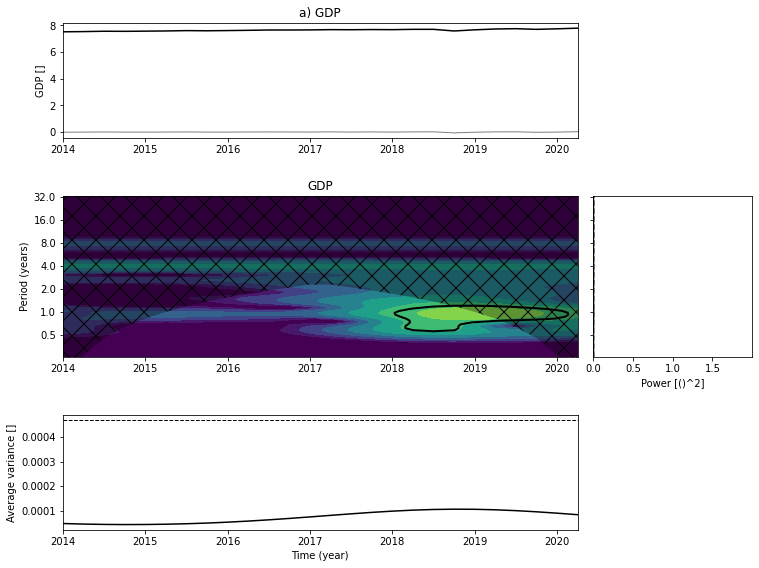

In [9]:
gdp= '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/gdp.txt'
dat = numpy.genfromtxt(gdp, skip_header=19)
title = 'GDP'
label = 'GDP'
units = ''
t0 = 2014.0
dt = 0.25 # In years
N = dat.size
t = numpy.arange(0, N) * dt + t0
p = numpy.polyfit(t - t0, dat, 1)
dat_notrend = dat - numpy.polyval(p, t - t0)
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
mother = wavelet.Morlet(6)
s0 = 1* dt  # Starting scale, in this case 2 * 0.25 years = 6 months
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj  # Seven powers of two with dj sub-octaves
#alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs
power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * numpy.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)
# Prepare the figure
pyplot.close('all')
pyplot.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = pyplot.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = pyplot.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = pyplot.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(numpy.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('GDP')
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** numpy.arange(numpy.ceil(numpy.log2(period.min())),
                           numpy.ceil(numpy.log2(period.max())))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = pyplot.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, numpy.log2(period), 'k--')
cx.plot(var * fft_theor, numpy.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
#cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(numpy.log2([period.min(), period.max()]))
cx.set_yticks(numpy.log2(Yticks))
cx.set_yticklabels(Yticks)
pyplot.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = pyplot.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
#dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

pyplot.show()

# Installing Ocatve Environment

In [10]:
pip install oct2py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 216 kB 53.8 MB/s 
     |████████████████████████████████| 133 kB 52.2 MB/s 
     |████████████████████████████████| 428 kB 60.7 MB/s 
     |████████████████████████████████| 132 kB 52.6 MB/s 
     |████████████████████████████████| 793 kB 37.4 MB/s 
     |████████████████████████████████| 381 kB 50.8 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uni

In [11]:
!apt install octave

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aglfn epstool fonts-droid-fallback fonts-noto-mono ghostscript gnuplot-data
  gnuplot-qt gsfonts imagemagick-6-common info install-info libamd2
  libauthen-sasl-perl libcamd2 libccolamd2 libcholmod3 libcolamd2
  libcupsfilters1 libcupsimage2 libcxsparse3 libdata-dump-perl libemf1
  libencode-locale-perl libfftw3-single3 libfile-listing-perl libfltk-gl1.3
  libfltk1.3 libfont-afm-perl libgail-common libgail18 libglpk40
  libgraphicsmagick++-q16-12 libgraphicsmagick-q16-3 libgs9 libgs9-common
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-mess

In [12]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [13]:
!octave


octave:1> 
octave:1> 
octave:1> attempting to save variables to 'octave-workspace'...
save to 'octave-workspace' complete



In [14]:
from oct2py import Oct2Py

In [15]:
pip install piwavelet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 531 kB 26.7 MB/s 


In [16]:
from piwavelet import piwavelet

Creating .piwavelet cache diretory in /root


In [51]:
t0 = 2014.0
dt = 0.10  # In years
time = numpy.arange(0, 89) * dt + t0

In [52]:
bitcoin = '/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/bitcoin.txt'


In [53]:
bitcoin=pd.read_table(bitcoin)



In [54]:
bitcoin.shape

(89, 1)

In [55]:
cpi="/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/cpi (1).txt"

In [56]:
cpi=pd.read_table(cpi)


In [64]:
gdp1='/content/gdrive/MyDrive/IIM K-Effects of crypto on economic indicators of India /datasets/gdp_formatted.txt'

In [65]:
gdp1=pd.read_table(gdp1)

In [66]:
gdp1.shape

(89, 1)

In [35]:
money_supply=pd.read_table(money_supply)

In [37]:
money_supply.shape

(89, 1)

In [44]:
cpi.shape

(89, 1)

In [33]:
x = 1
y = 2
display(x+y)

3

# wavelet coherence BTC VS CPI

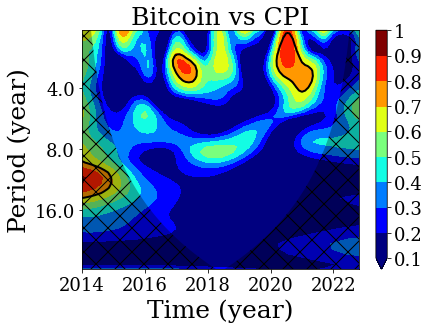

In [57]:
mycoherence = piwavelet.wcoherence(bitcoin,cpi)
mycoherence.plot(t = time, title='Bitcoin vs CPI',units='year')

# wavelet coherence BTC VS Money supply

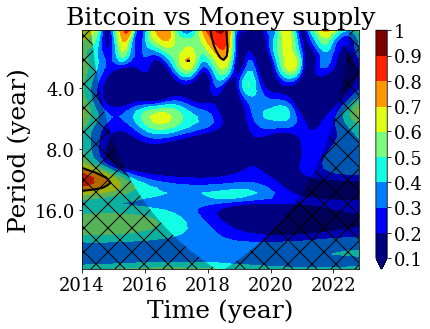

In [59]:
mycoherence = piwavelet.wcoherence(bitcoin,money_supply)
mycoherence.plot(t = time, title='Bitcoin vs Money supply',units='year')

# wavelet coherence BTC VS GDP

Streaming output truncated to the last 5000 lines.
       ####################

















                Running Monte Carlo (significance)... (H=le)

       #####################
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #####################

















                Running Monte Carlo (significance)... (H=le)

       #####################
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #####################

















                Running Monte Carlo (significance)... (H=le)

       #####################
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #####################

















                Running Monte Carlo (significance)... (H=le)

       #####################
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #XXXXXXXXXXXXXXXXXXX#
       #####################

















        

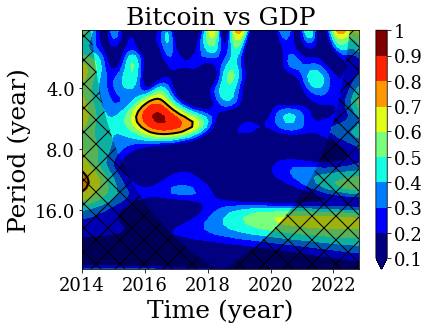

In [68]:
mycoherence = piwavelet.wcoherence(bitcoin,gdp1)
mycoherence.plot(t = time, title='Bitcoin vs GDP',units='year')